# Minimal BERT Training with HuggingFace Transformers

HF公式実装でallenai/c4 realnewslikeデータセットが学習できるかを検証する。

In [8]:
import torch
from transformers import (
    BertConfig,
    BertForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset

## 1. データセット準備

In [9]:
# Tokenizerの準備
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# データセット読み込み
dataset = load_dataset("allenai/c4", "realnewslike", split="train[:200000]")
print(f"Dataset loaded: {len(dataset)} samples")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Dataset loaded: 200000 samples


In [10]:
# トークナイズ
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=128,  # 短めにして学習を速く
        return_special_tokens_mask=True,
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=dataset.column_names,
)

print(f"Dataset tokenized: {len(tokenized_dataset)} samples")

Dataset tokenized: 200000 samples


## 2. モデル準備

In [11]:
# BERTの標準設定を使う
config = BertConfig.from_pretrained("bert-base-uncased")
model = BertForMaskedLM(config)

assert(config.vocab_size == tokenizer.vocab_size)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 109,514,298


## 3. DataCollator準備

In [12]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)

print("DataCollator configured")

DataCollator configured


## 4. Trainer設定と訓練

In [13]:
from transformers import TrainerCallback

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    learning_rate=1e-4,
    weight_decay=0.01,
    warmup_ratio=0.06,
    save_strategy="epoch",
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

print("Trainer configured. Starting training...")

Trainer configured. Starting training...


In [14]:
# 訓練実行
train_result = trainer.train()

print(f"\n{'='*50}")
print(f"Training completed!")
print(f"Final loss: {train_result.training_loss:.4f}")
print(f"{'='*50}")

Step,Training Loss
500,8.127200
1000,7.030900
1500,6.887600
2000,6.766700
2500,6.700900
3000,6.647100
3500,6.595700
4000,6.552900
4500,6.518800
5000,6.487700


/Users/neet/ghq/github.com/neet/attentif/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/neet/ghq/github.com/neet/attentif/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Training completed!
Final loss: 5.7577


## 5. Loss曲線の可視化

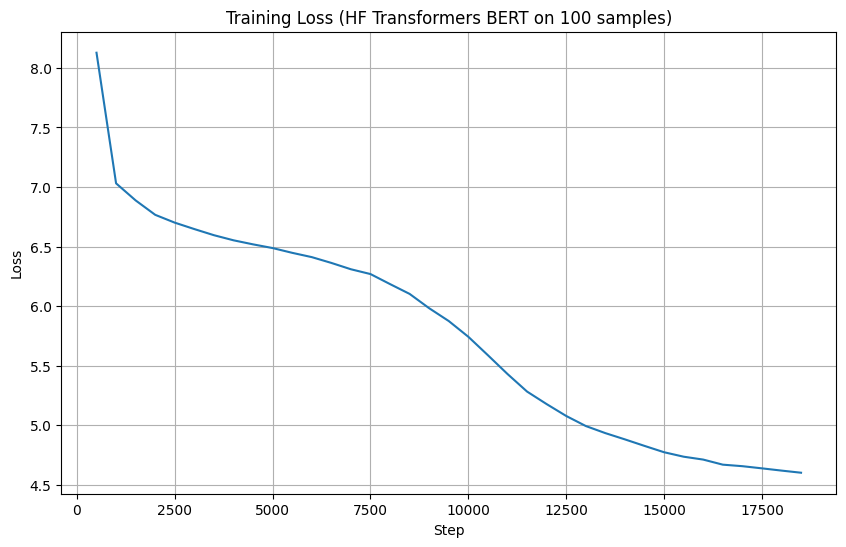


Initial loss: 8.1272
Final loss: 4.6022
Loss reduction: 3.5250


In [15]:
import matplotlib.pyplot as plt

# ログから損失を取得
log_history = trainer.state.log_history
losses = [log["loss"] for log in log_history if "loss" in log]
steps = [log["step"] for log in log_history if "loss" in log]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss (HF Transformers BERT on 100 samples)")
plt.grid(True)
plt.show()

if len(losses) > 0:
    print(f"\nInitial loss: {losses[0]:.4f}")
    print(f"Final loss: {losses[-1]:.4f}")
    print(f"Loss reduction: {losses[0] - losses[-1]:.4f}")

## 期待される結果

- ✅ **Loss < 1.0に到達**: データセットは正常。自作実装に問題がある
- ❌ **Loss ~ 7.0で停滞**: データセット自体に問題がある可能性